## Business Goal: Determine if there is a relationship between the changes of sentiment in soccer subreddits and match results.

In [8]:
# Setup - Run only once per Kernel App
# %conda install openjdk -y

# # install PySpark
# %pip install pyspark==3.2.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [9]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as f
from pyspark.sql.functions import when, col, desc, regexp_replace, lower, udf, to_date
from pyspark.sql import DataFrame
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, VectorAssembler, StringIndexer
from pyspark.sql.types import BooleanType, StringType, DateType, IntegerType, DoubleType
from pyspark.ml import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Read in data

In [10]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.executor.memory", "10g")
    .config("spark.driver.memory", "10g")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

3.2.0


In [11]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=3600,
)

# s3 paths
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_logs = f"spark_logs"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 331 ms, sys: 4.52 ms, total: 335 ms
Wall time: 498 ms


In [12]:
%%time
df_path = f"reddit_soccer_data/"
s3_path = f"s3a://{bucket}/{df_path}"
print(f"reading submissions from {s3_path}")
df = spark.read.parquet(s3_path, header=True)
print(f"shape of the dataframe is {df.count():,}x{len(df.columns)}")

reading submissions from s3a://sagemaker-us-east-1-634977863454/reddit_soccer_data/


shape of the dataframe is 5,617,852x9
CPU times: user 31.2 ms, sys: 7.83 ms, total: 39.1 ms
Wall time: 59.5 s


### Retrieve data from 3 most popular clubs

In [13]:
# Select only the required columns
selected_df = df.select('author_flair_text', 'body', 'created_utc', 'score', 'subreddit')

# DataFrame for Arsenal
df_arsenal = selected_df.filter(
    (col('subreddit') == 'Gunners') | 
    ((col('subreddit') == 'soccer') & (col('author_flair_text') == ':Arsenal:'))
)

# DataFrame for Manchester United
df_man_united = selected_df.filter(
    (col('subreddit') == 'reddevils') | 
    ((col('subreddit') == 'soccer') & (col('author_flair_text') == ':Manchester_United:'))
)

# DataFrame for Chelsea
df_chelsea = selected_df.filter(
    (col('subreddit') == 'chelseafc') | 
    ((col('subreddit') == 'soccer') & (col('author_flair_text') == ':Chelsea:'))
)

### Cleaning texts on the created dataframes

In [14]:
# Removing non-alphanumeric characters
df_arsenal = df_arsenal.withColumn('clean_body', regexp_replace('body', '[^A-Za-z0-9\s]+', ''))
df_man_united = df_man_united.withColumn('clean_body', regexp_replace('body', '[^A-Za-z0-9\s]+', ''))
df_chelsea = df_chelsea.withColumn('clean_body', regexp_replace('body', '[^A-Za-z0-9\s]+', ''))

# Converting to lowercase
df_arsenal = df_arsenal.withColumn('clean_body', lower(col('clean_body')))
df_man_united = df_man_united.withColumn('clean_body', lower(col('clean_body')))
df_chelsea = df_chelsea.withColumn('clean_body', lower(col('clean_body')))

# Tokenize text
tokenizer = Tokenizer(inputCol='clean_body', outputCol='words')
df_arsenal = tokenizer.transform(df_arsenal)

tokenizer = Tokenizer(inputCol='clean_body', outputCol='words')
df_man_united = tokenizer.transform(df_man_united)

tokenizer = Tokenizer(inputCol='clean_body', outputCol='words')
df_chelsea = tokenizer.transform(df_chelsea)

# Remove stop words
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
df_arsenal = remover.transform(df_arsenal)

remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
df_man_united = remover.transform(df_man_united)

remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
df_chelsea = remover.transform(df_chelsea)

In [15]:
df_arsenal = df_arsenal.withColumn('date', to_date('created_utc'))
df_arsenal = df_arsenal.drop('created_utc')

df_man_united = df_man_united.withColumn('date', to_date('created_utc'))
df_man_united = df_man_united.drop('created_utc')

df_chelsea = df_chelsea.withColumn('date', to_date('created_utc'))
df_chelsea = df_chelsea.drop('created_utc')

### Sentiment analysis on the relation of each team fans' comments and the match result of the team

In [16]:
try:
    matches = pd.read_csv('./top_5_teams_scores.csv')
except Exception as e:
    print(e)

In [17]:
matches['date'] = pd.to_datetime(matches['date'], format='%m/%d/%Y')
# Verify the changes
matches.head()

,team,opponent,date,scored,conceded,outcome,tournament
0,Arsenal,Newcastle,2023-01-03,0,0,draw,Premier League
1,Arsenal,Oxford Utd,2023-01-09,3,0,win,FA Cup
2,Arsenal,Tottenham,2023-01-15,2,0,win,Premier League
3,Arsenal,Man United,2023-01-22,3,2,win,Premier League
4,Arsenal,Man City,2023-01-27,0,1,loss,FA Cup


### Arsenal: plot the 1. Daily sentiment counts 2. Daily sentiment ratio

In [18]:
arsenal_matches = matches.loc[matches["team"]=='Arsenal',:]
arsenal_sentiments = pd.read_csv("./arsenal_match_sentiment.csv")

# Pivot the DataFrame
arsenal_pivot_df = arsenal_sentiments.pivot_table(index='date', columns='sentiment_score', values='count').reset_index()

# Fill NaN values with 0
arsenal_pivot_df = arsenal_pivot_df.fillna(0)

arsenal_pivot_df['date'] = pd.to_datetime(arsenal_pivot_df['date'], format='%Y-%m-%d')

# Verify the changes
arsenal_pivot_df.head()

sentiment_score,date,negative,neutral,positive
0,2023-01-01,4211,498,4706
1,2023-01-02,4033,455,3984
2,2023-01-03,9458,749,6572
3,2023-01-04,4501,433,3380
4,2023-01-05,4146,403,3499


In [19]:
df_arsenal = (pd.merge(arsenal_matches, arsenal_pivot_df, on='date', how='outer')).sort_values(by='date').reset_index(drop=True)
df_arsenal = df_arsenal.drop(["team", "opponent", "scored", "conceded", "tournament"], axis=1)
df_arsenal.head()

,date,outcome,negative,neutral,positive
0,2023-01-01,NaN,4211,498,4706
1,2023-01-02,NaN,4033,455,3984
2,2023-01-03,draw,9458,749,6572
3,2023-01-04,NaN,4501,433,3380
4,2023-01-05,NaN,4146,403,3499


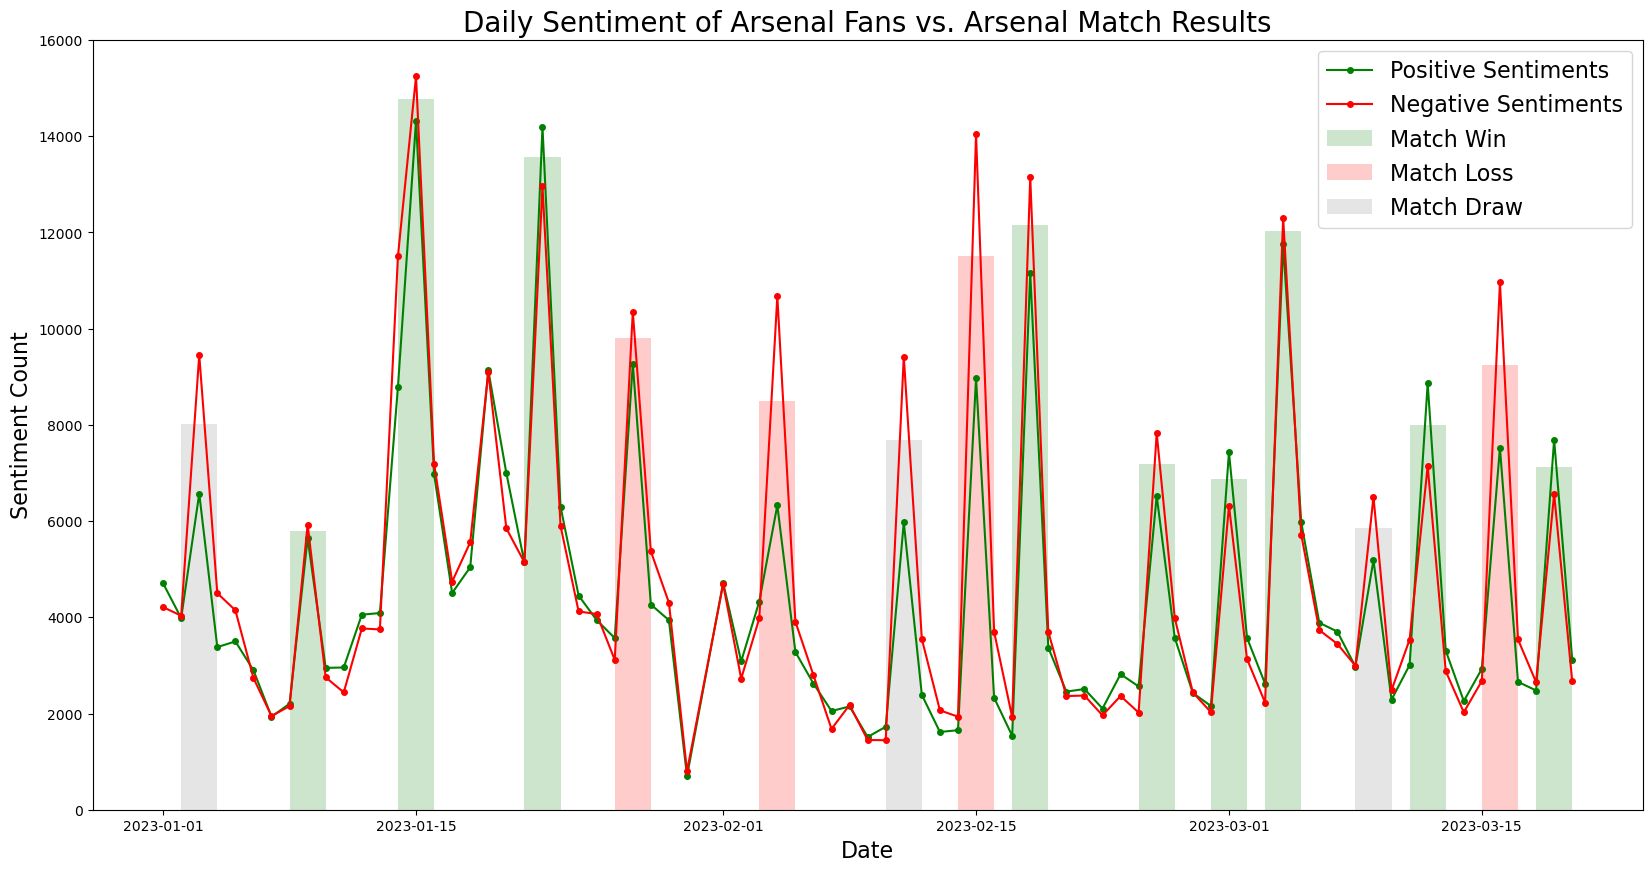

In [20]:
df_arsenal = df_arsenal[df_arsenal['date'] <= '2023-03-20']

# Create a figure and a set of subplots
plt.figure(figsize=(20,10))

# Plotting positive and negative sentiments as lines
plt.plot(df_arsenal['date'], df_arsenal['positive'], label='Positive Sentiments', color='green', marker='o', markersize=4)
plt.plot(df_arsenal['date'], df_arsenal['negative'], label='Negative Sentiments', color='red', marker='o', markersize=4)

# Adding bars for match results
for outcome, color in zip(['win', 'loss', 'draw'], ['green', 'red', 'grey']):
    match_days = df_arsenal[df_arsenal['outcome'] == outcome]
    plt.bar(match_days['date'], (match_days['positive']+match_days['negative'])/2, color=color, alpha=0.2, label=f'Match {outcome.title()}', width=2)

# Adding labels and title
plt.xlabel('Date', fontsize=16)
plt.ylabel('Sentiment Count', fontsize=16)
plt.title('Daily Sentiment of Arsenal Fans vs. Arsenal Match Results', fontsize=20)

# Adding legend
plt.legend(fontsize=16)

# Show plot
plt.show()

This is a combined line and bar plot, showing the number of comments from Arsenal fans of positive and negative sentiments as lines, and the match result as bars (also showing the average number of positive and negative comments on matchdays).

We can draw some interesting findings from this sentiment analysis: First, on the date when there was a match for Arsenal the comments number are much higher than the days when there was no match; Second, Arsenal fans tend to have rather balanced sentiments in their comments when there is no matches, however when Arsenal lost or draw a game, the number of negative comments are always higher than the positive comments, many times much higher. Even when Arsenal won, the fans did not really show much more positivity, sometimes even more negative when a match was won. Consider Arsenal has historically not been doing great during January to March, as they lost their leading position in the premier league in this time in 2023, it is understandable that their fans are not very optimistic.

### Feedback discussion: Professor mentiosn that it could be interesting to show a similar chart and have a positive/negative ratio for the lines, so a similar chart where the line showing the ratio is added. The plot of single line of the positive/negative comments ratio can be more straightfoward than the plot of 2 lines of both positive and negative comments. 

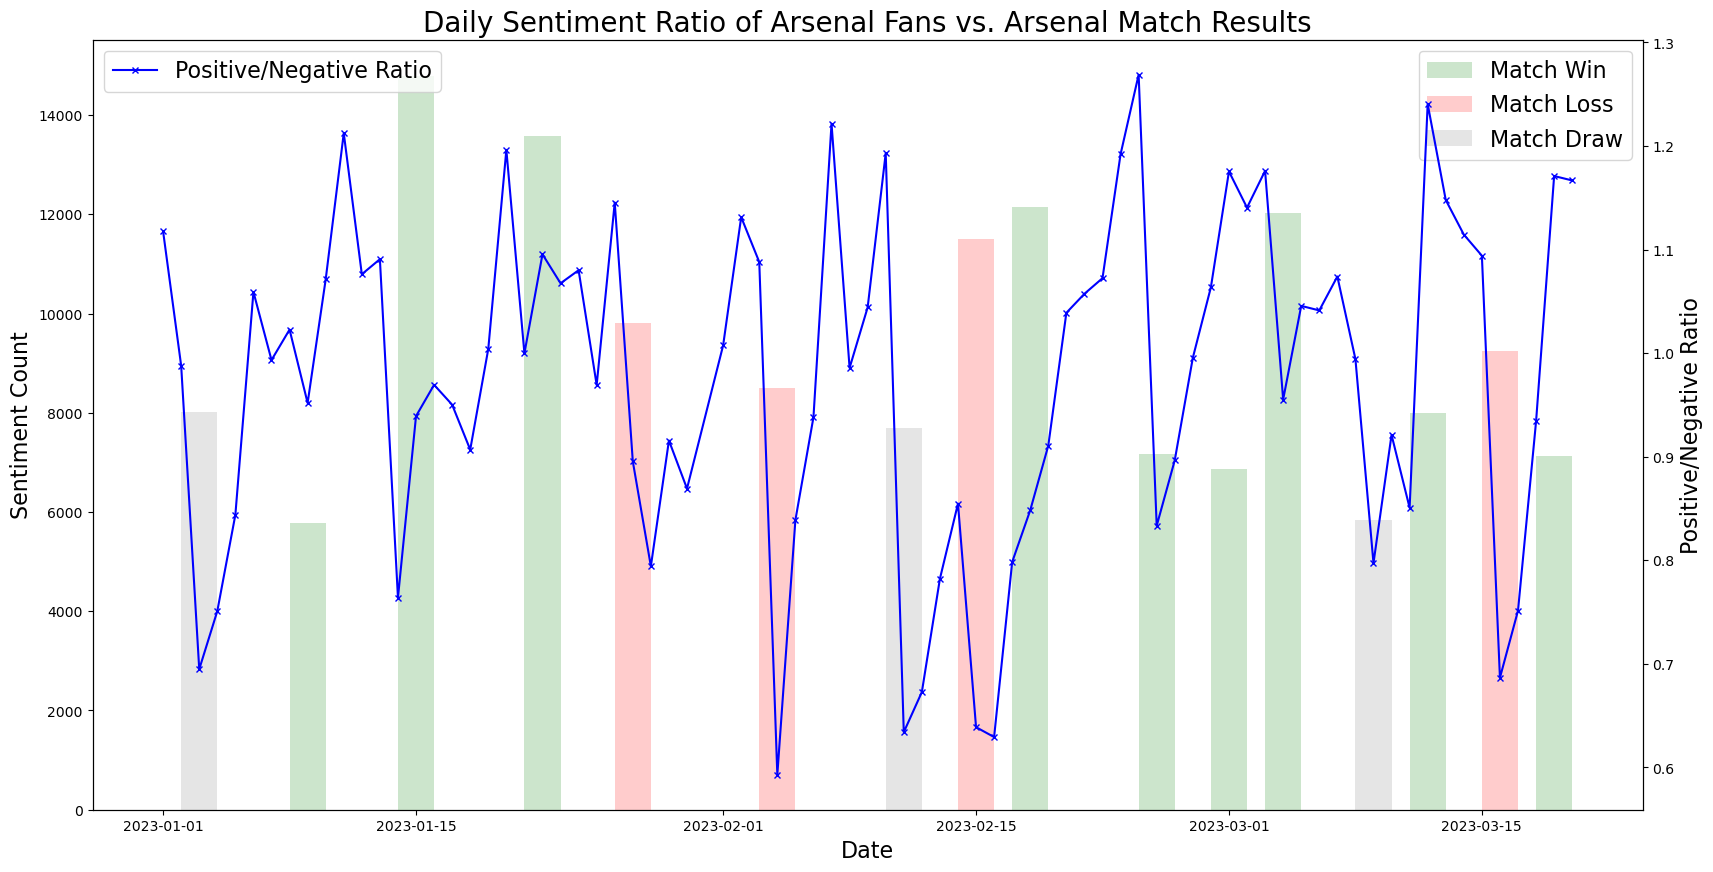

In [23]:
# Create a figure and a set of subplots
plt.figure(figsize=(20,10))

# Adding bars for match results
for outcome, color in zip(['win', 'loss', 'draw'], ['green', 'red', 'grey']):
    match_days = df_arsenal[df_arsenal['outcome'] == outcome]
    plt.bar(match_days['date'], (match_days['positive']+match_days['negative'])/2, color=color, alpha=0.2, label=f'Match {outcome.title()}', width=2)

# Adding labels and title
plt.xlabel('Date', fontsize=16)
plt.ylabel('Sentiment Count', fontsize=16)
plt.title('Daily Sentiment Ratio of Arsenal Fans vs. Arsenal Match Results', fontsize=20)

# Adding legend
plt.legend(fontsize=16)

# Creating a second y-axis for the positive/negative ratio
ax2 = plt.twinx()
ax2.plot(df_arsenal['date'], df_arsenal['positive']/df_arsenal['negative'], label='Positive/Negative Ratio', color='blue', marker='x', markersize=4)
ax2.set_ylabel('Positive/Negative Ratio', fontsize=16)
ax2.legend(loc='upper left', fontsize=16)

# Save the output
plt.savefig('./arsenal_match_sentiment_ratio.png')

# Show plot
plt.show()

This map represents the ratio of number of positive comments to negative comments on each day for Arsenal fans, along with the match results for Arsenal. In this plot, a similar interesting finding is that the days that have the lowest sentiment ratio are always the days that the team lost the match or had a draw. This is a reasonable result, since a bad losing day will make the fans upset. However, it is also found that a winning match day does not always generate a good sentiment ratio, and the highest ratio often happends on non-match days. We can infer from this result that, at least for Arsenal fans, the sentiment is more normal or positive on non-match days. Even if the team is winning, the fans might still be upset about the team's performance.  